# Bayesian Project
## Predicting NBA Win Projections
Nick Clifford, Brigitte Hogan, Kevin Malloy

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import theano.tensor as tt

## Messy Data

In [238]:
ball = pd.read_csv('bask_ordered.csv')
ball.head()

,City,Team,Abb,Proj_19.20,Final_18.19,Proj_18.19,Final_17.18,Proj_17.18,Final_16.17,Proj_16.17,...,Games_19:20,Wins_18:19,Loss_18:19,Games_18:19,Wins_17:18,Loss_17:18,Games_17:18,Wins_16:17,Loss_16:17,Games_16:17
0,Atlanta,Hawks,ATL,32.5,29,23.5,24,25.5,43,43.5,...,22,5,20,25,5,18,23,10,12,22
1,Boston,Celtics,BOS,48.5,49,59.0,55,54.5,53,52.5,...,20,13,10,23,21,4,25,12,9,21
2,Brooklyn,Nets,BRK,50.5,42,32.5,28,28.0,20,21.5,...,21,8,18,26,9,14,23,5,15,20
3,Charlotte,Hornets,CHO,32.5,39,36.0,36,42.5,36,42.5,...,23,11,13,24,9,13,22,12,9,21
4,Chicago,Bulls,CHI,27.5,22,30.0,27,22.0,41,39.0,...,22,5,20,25,3,19,22,11,9,20


In [239]:
year_cols = ball.columns[3:]
nonyear_cols = ball.columns[:3]
ball = pd.melt(ball, id_vars = nonyear_cols, value_vars = year_cols, var_name='year')

In [240]:
ball['Year'] = ball['year'].str.split('_').str[1]
ball['type'] = ball['year'].str.split('_').str[0]
ball['Year'] = ball['Year'].str.split(':').str.join('-').str.split('.').str.join('-')
ball.drop('year', axis=1, inplace=True)

In [241]:
ball = ball.pivot_table(index=['City', 'Team', 'Abb', 'Year'],
                                columns='type',
                                values='value',
                                aggfunc='first')
ball = pd.DataFrame(ball.to_records())

In [342]:
ball.to_csv(path_or_buf='bask_clean.csv')

TypeError: to_csv() got an unexpected keyword argument 'dtype'

## Clean Data

In [2]:
ball = pd.read_csv('bask_clean.csv', dtype={'Abb':'category'})
ball.head()

,Unnamed: 0,City,Team,Abb,Year,Final,Games,Loss,Proj,Wins
0,0,Atlanta,Hawks,ATL,16-17,43.0,22.0,12.0,43.5,10.0
1,1,Atlanta,Hawks,ATL,17-18,24.0,23.0,18.0,25.5,5.0
2,2,Atlanta,Hawks,ATL,18-19,29.0,25.0,20.0,23.5,5.0
3,3,Atlanta,Hawks,ATL,19-20,NaN,22.0,17.0,32.5,5.0
4,4,Boston,Celtics,BOS,16-17,53.0,21.0,9.0,52.5,12.0


Columns:
- **Final**: total # of team's wins out of 82 games (not including 2019-2020)
- **Games**: total # of games played up to December 5th of that season
- **Wins** : # of team's wins up to December 5th of that season
- **Loss** : # of team's losses up to December 5th of that season
- **Proj** : Team's pre-season projected # of wins out of 82 games


## Conjugate Prior Approach

Prior Distribution (Pre-Season Projection): 
- Beta($\alpha$, $\beta$)
- Expected value = $\frac{\alpha}{\alpha + \beta}$ = $\frac{\text{projected games won}}{\text{projected games won} - (82 - \text{projected games won)}}$
- $\alpha$ = projected games won 
- $\beta$ = 82 - projected games won

Posterior (New Projection):
- Beta($\alpha^*$, $\beta^*$)
- Expected value = $\frac{\alpha + Y}{(\alpha + Y) + (\beta + N - Y)}$ 
- $\alpha^*$ = ${\alpha + \text{wins}_{d}}$
- $\beta^*$ = ${\beta + \text{total}_{d} - \text{wins}_d}$


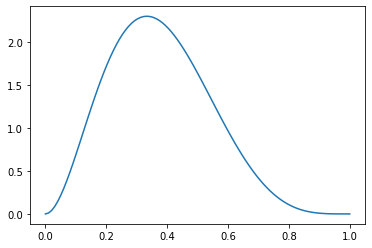

In [284]:
x = np.linspace(0,1,100)
y = stats.beta(3, 5).pdf(x)

plt.plot(x, y)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


Text(0.5, 0, '| Projection - Wins |')

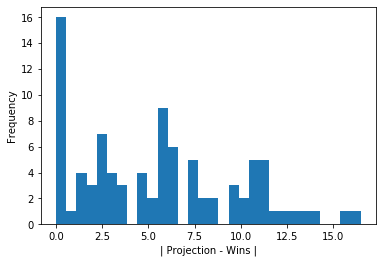

In [326]:
np.abs(ball['Proj'] - ball['Final']).plot('hist', bins=30)
plt.xlabel('| Projection - Wins |')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


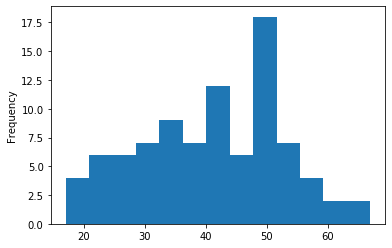

In [337]:
ball['Final'].plot('hist', bins=13)

In [349]:
team_idx = ball.Abb.cat.codes.values
team_codes = ball.Abb.cat.categories
n_teams = team_codes.size

In [441]:
team_idx = current.Abb.cat.codes.values
team_codes = current.Abb.cat.categories
n_teams = team_codes.size

In [491]:
df18 = ball.query('Year=="18-19"')
team_idx = df18.Abb.cat.codes.values
team_codes = df18.Abb.cat.categories
n_teams = team_codes.size

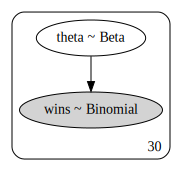

In [526]:
with pm.Model() as model1:
#    scale = pm.Gamma('scale', 2, 2)
#    alpha = pm.Deterministic('alpha', pm.math.dot(scale, current['alpha']))
#    beta = pm.Deterministic('beta', pm.math.dot(scale, current['beta']))
    alpha = pm.math.dot(1, df18['alpha'].T)
    beta = pm.math.dot(1, df18['beta'].T)
#    alpha = pm.Gamma('alpha', 2, 2)
#    beta = pm.Gamma('beta', 2, 2)
    theta = pm.Beta('theta', alpha, beta, shape=n_teams)
    
    y = pm.Binomial('wins', n=n_teams, p=theta[team_idx], observed=df18.Wins)    

pm.model_to_graphviz(model1)

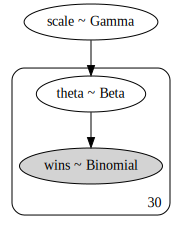

In [684]:
with pm.Model() as model2:
    scale = pm.Gamma('scale', 2, .5)
#    alpha = pm.Deterministic('alpha', pm.math.dot(scale, current['alpha']))
#    beta = pm.Deterministic('beta', pm.math.dot(scale, current['beta']))
    alpha = pm.math.dot(scale, df18['alpha'].T)
    beta = pm.math.dot(scale, df18['beta'].T)
#    alpha = pm.Gamma('alpha', 2, 2)
#    beta = pm.Gamma('beta', 2, 2)
    theta = pm.Beta('theta', alpha, beta, shape=n_teams)
    
    y = pm.Binomial('wins', n=n_teams, p=theta[team_idx], observed=df18.Wins)    

pm.model_to_graphviz(model2)

In [533]:
with model1:
    fit1 = pm.fit(10000)

Average Loss = 94.769: 100%|██████████| 10000/10000 [04:24<00:00, 37.86it/s]
Finished [100%]: Average Loss = 94.763


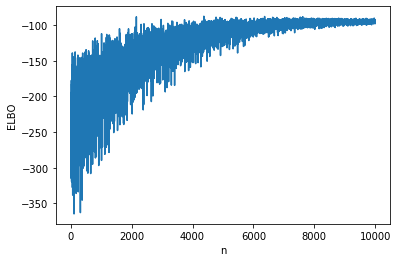

In [536]:
advi_elbo = pd.DataFrame(
    {'ELBO': fit1.hist,
     'n': np.arange(fit1.hist.shape[0])})

plt.plot(-fit1.hist)
plt.xlabel('n')
plt.ylabel('ELBO');

In [537]:
with model2:
    fit2 = pm.fit(10000)

Average Loss = 90.782: 100%|██████████| 10000/10000 [05:09<00:00, 32.35it/s]
Finished [100%]: Average Loss = 90.773


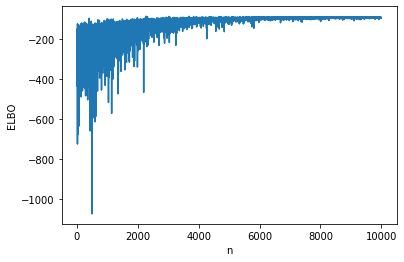

In [546]:
advi_elbo = pd.DataFrame(
    {'ELBO': fit2.hist,
     'n': np.arange(fit2.hist.shape[0])})

plt.plot(-fit2.hist)
plt.xlabel('n')
plt.ylabel('ELBO');

In [548]:
with model2:
    fit3 = pm.fit(5000)

Average Loss = 126.67: 100%|██████████| 5000/5000 [02:22<00:00, 35.07it/s]
Finished [100%]: Average Loss = 126.31


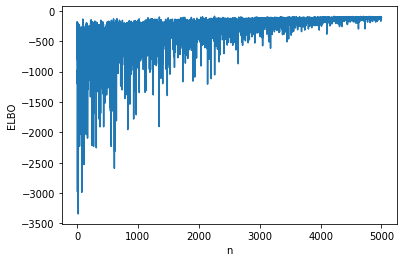

In [549]:
advi_elbo = pd.DataFrame(
    {'ELBO': fit3.hist,
     'n': np.arange(fit3.hist.shape[0])})

plt.plot(-fit3.hist)
plt.xlabel('n')
plt.ylabel('ELBO');

In [539]:
trace1 = fit1.sample(5000)

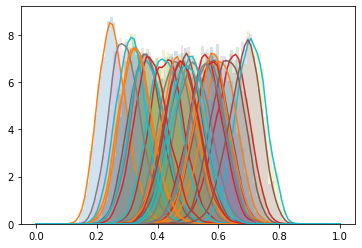

In [605]:
for i in list(range(30)):
    plt.hist(trace1['theta'].T[i], bins=40, density=True, alpha=0.2)
    plt.plot(x_range, stats.gaussian_kde(trace1['theta'].T[i]).pdf(x_range))
plt.show()

In [540]:
trace2 = fit2.sample(5000)

In [550]:
trace3 = fit3.sample(5000)

In [369]:
ball['alpha'] = ball['Proj']
ball['beta'] = 82 - ball['Proj']

In [380]:
current = ball.query('Year=="19-20"')

current['alpha_post'] = current['alpha'] + current['Wins']
current['beta_post'] = current['beta'] + current['Games'] - current['Wins']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


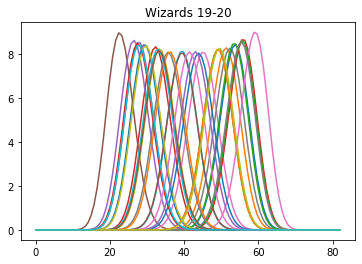

In [508]:
x = np.linspace(0,1,100)
for i in range(len(current)):
    y = stats.beta.pdf(x, current.iloc[i]['alpha_post'], current.iloc[i]['beta_post'])
    plt.plot(x*82, y)
    plt.title(current.iloc[i]['Team'] + " " + current.iloc[i]['Year'])
plt.show()

In [649]:
past = ball.query('Year!="19-20"')

past['alpha_post'] = past['alpha'] + past['Wins']
past['beta_post'] = past['beta'] + past['Games'] - past['Wins']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [562]:
ball[ball['Team'] == 'Bulls']

,Unnamed: 0,City,Team,Abb,Year,Final,Games,Loss,Proj,Wins,alpha,beta
16,16,Chicago,Bulls,CHI,16-17,41.0,20.0,9.0,39.0,11.0,39.0,43.0
17,17,Chicago,Bulls,CHI,17-18,27.0,22.0,19.0,22.0,3.0,22.0,60.0
18,18,Chicago,Bulls,CHI,18-19,22.0,25.0,20.0,30.0,5.0,30.0,52.0
19,19,Chicago,Bulls,CHI,19-20,NaN,22.0,14.0,27.5,8.0,27.5,54.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


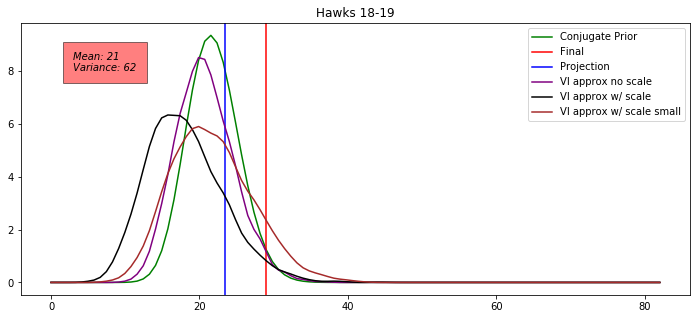

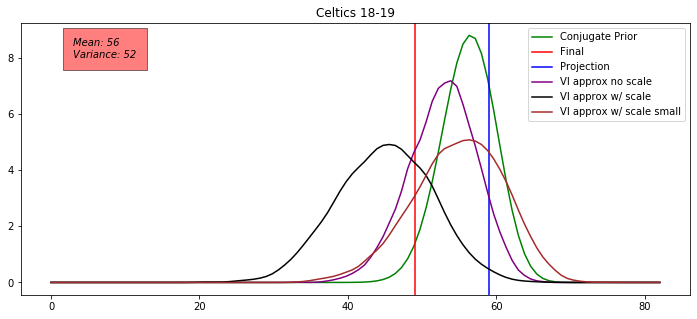

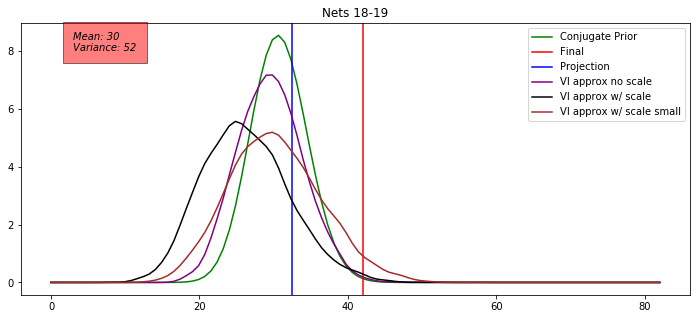

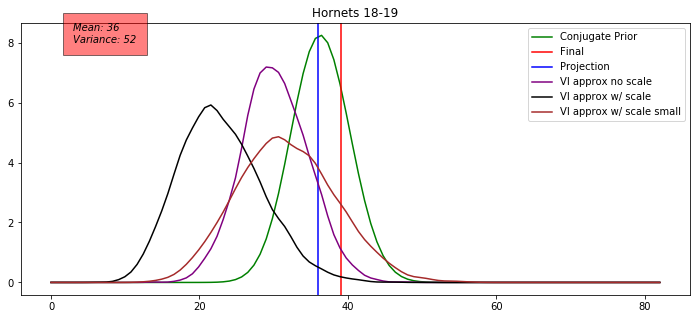

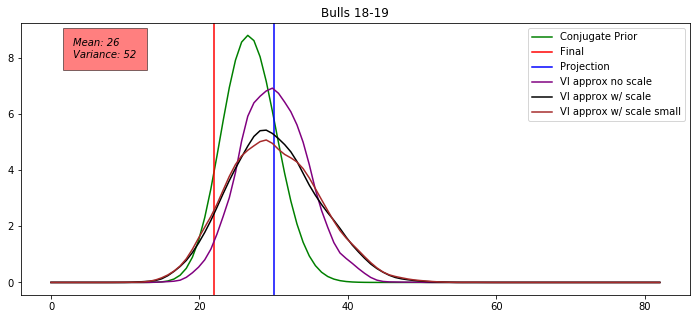

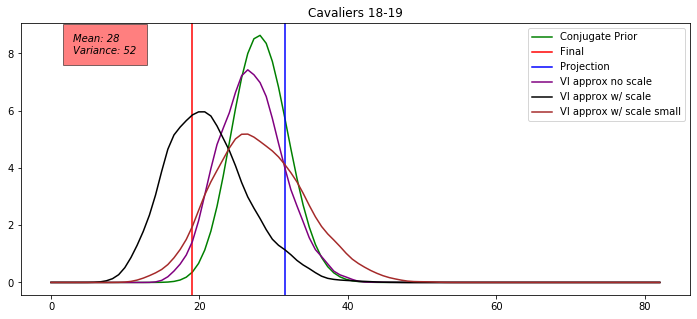

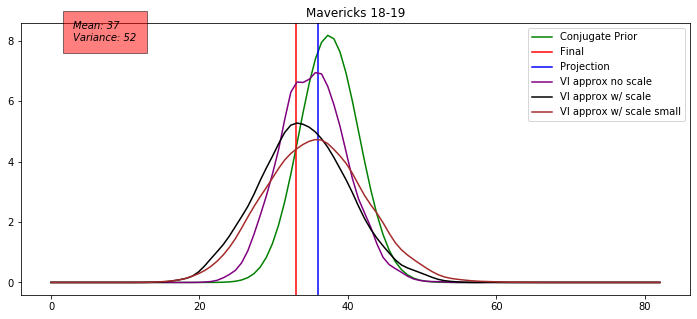

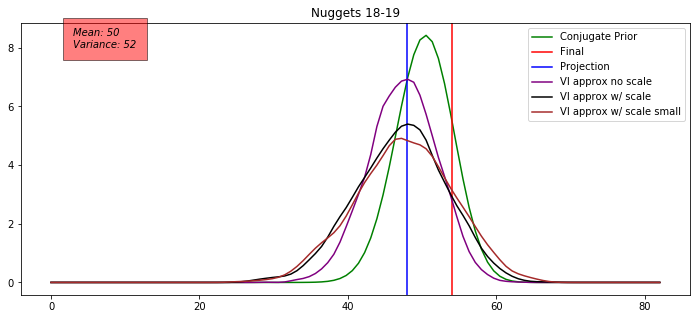

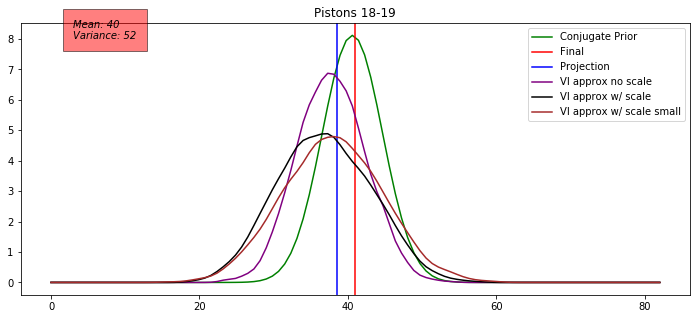

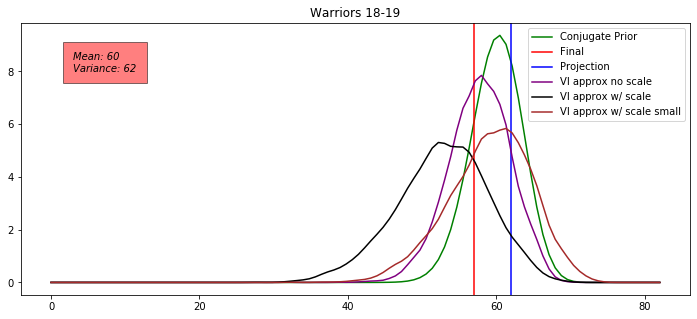

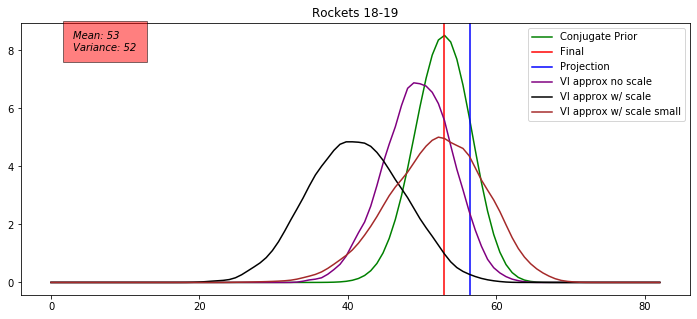

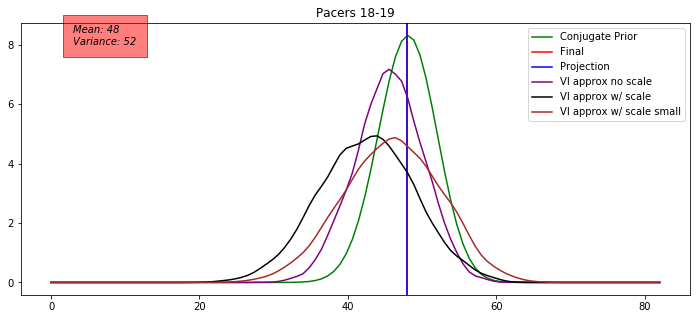

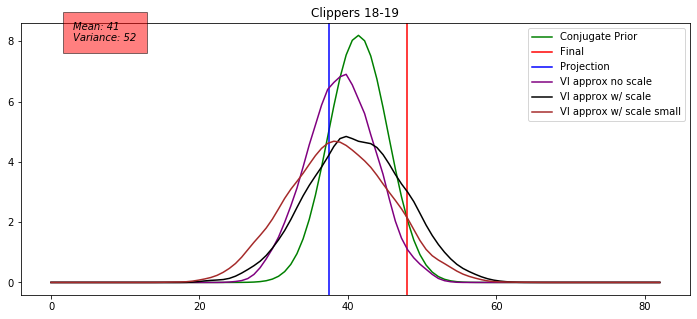

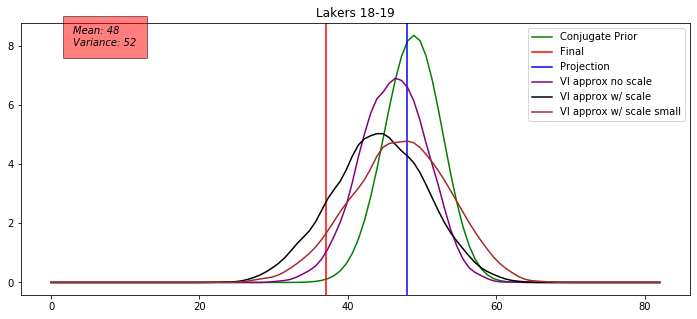

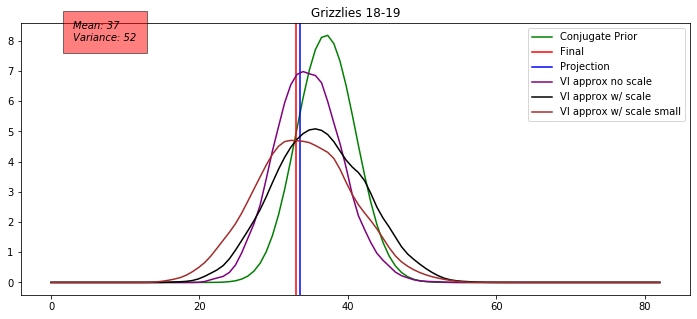

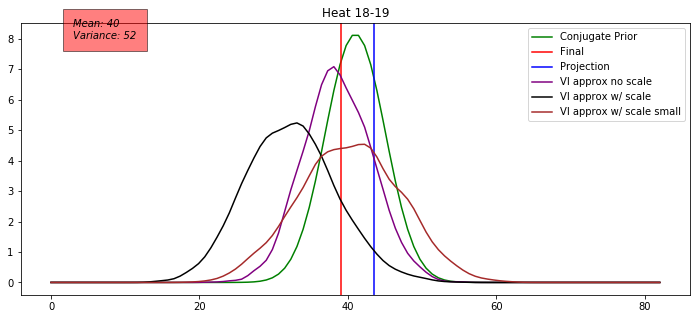

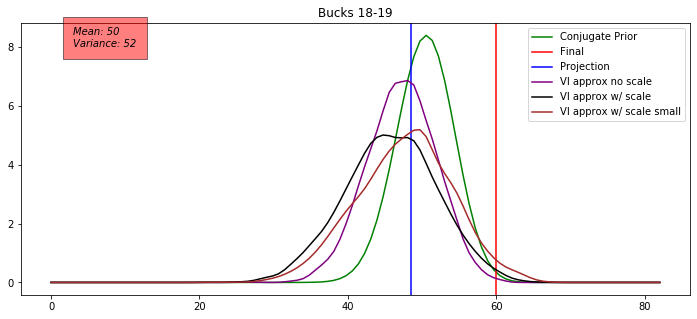

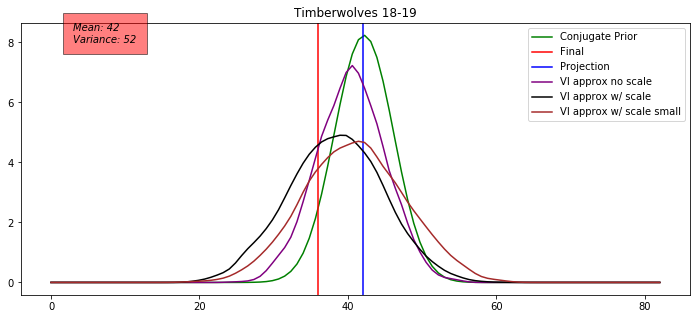

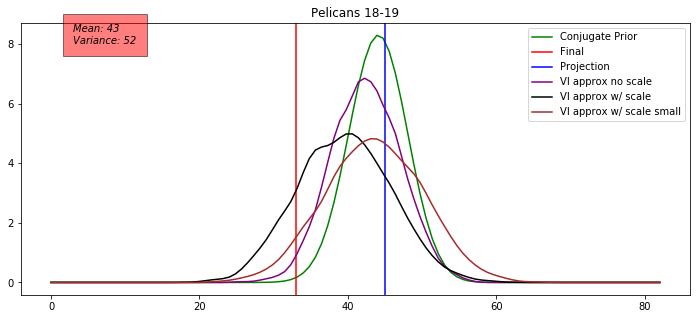

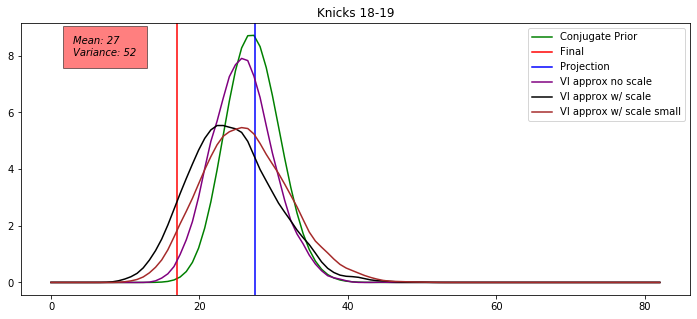

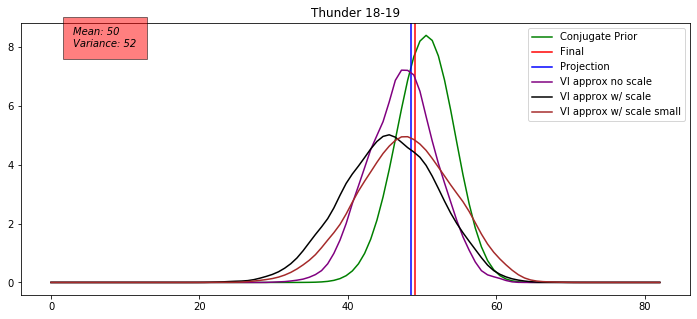

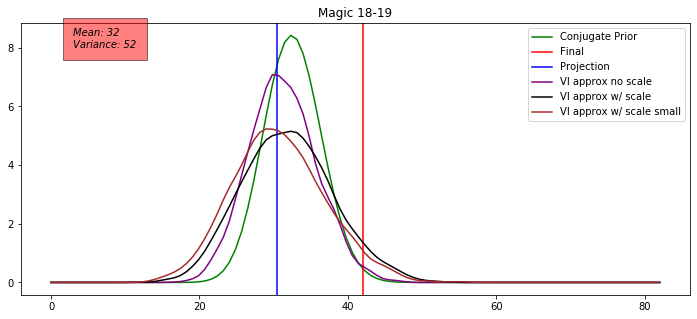

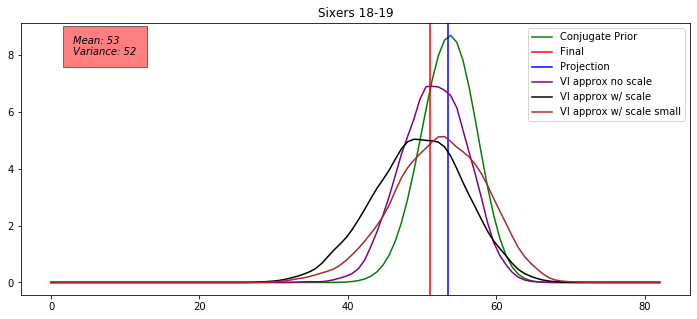

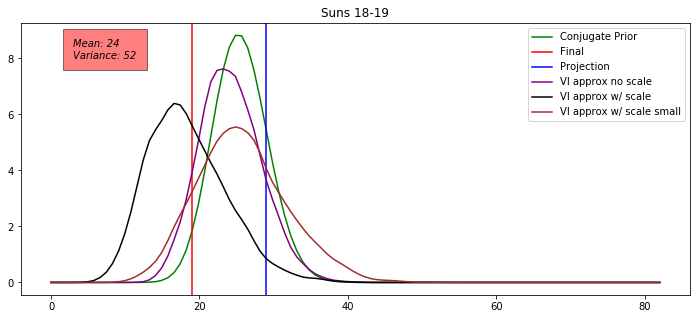

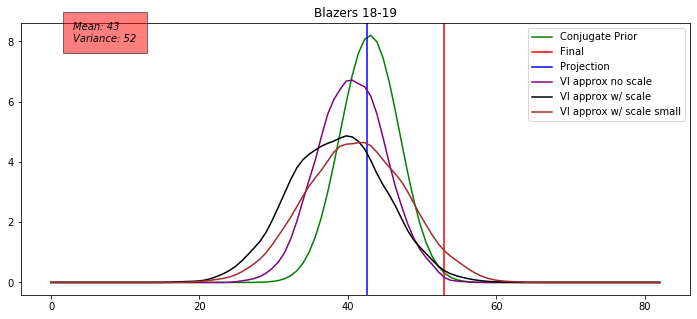

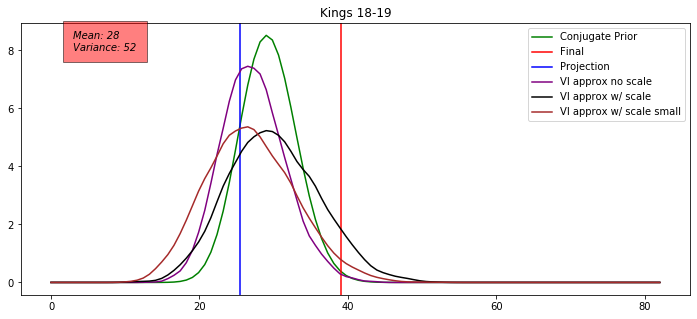

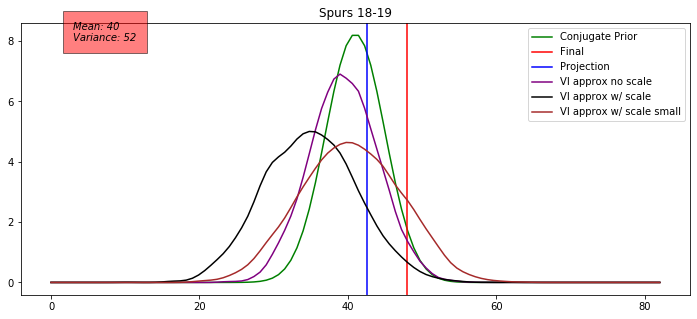

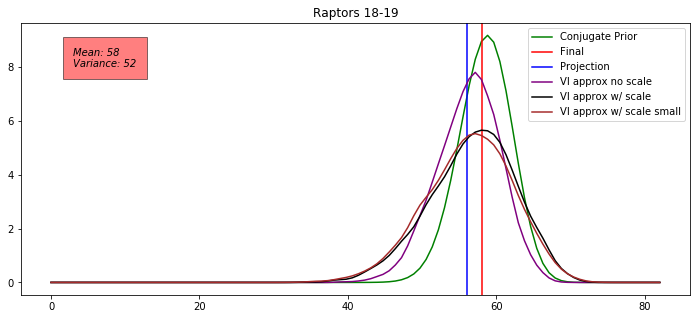

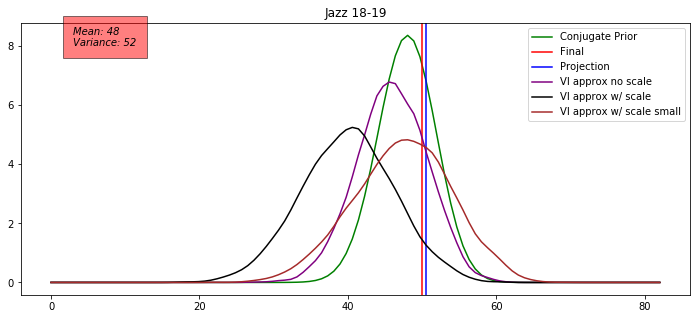

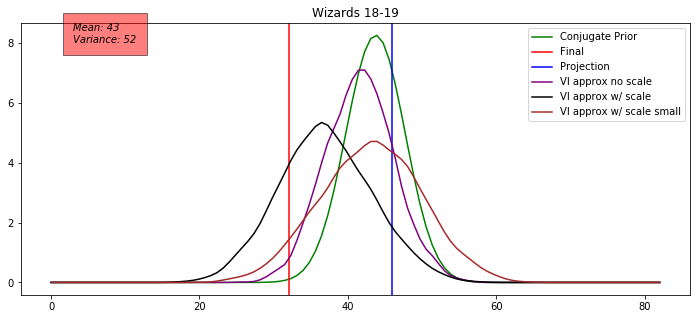

In [607]:
x = np.linspace(0,1,100)
fig, ax = plt.subplots(5,6)
for i in range(len(past)):
    y = stats.beta.pdf(x, past.iloc[i]['alpha_post'], past.iloc[i]['beta_post'])
    plt.figure(figsize=[12,5])
    plt.plot(x*82, y, color = 'green', label='Conjugate Prior')
    plt.title(past.iloc[i]['Team'] + " " + past.iloc[i]['Year'])
    plt.axvline(past.iloc[i]['Final'], color = 'red', label = 'Final')
    plt.axvline(past.iloc[i]['Proj'], color = 'blue', label = 'Projection')
    plt.plot(x_range*82, stats.gaussian_kde(trace1['theta'].T[i]).pdf(x_range), color = 'purple',label='VI approx no scale')
    plt.plot(x_range*82, stats.gaussian_kde(trace2['theta'].T[i]).pdf(x_range), color = 'k',label='VI approx w/ scale')
    plt.plot(x_range*82, stats.gaussian_kde(trace3['theta'].T[i]).pdf(x_range), color = 'brown',label='VI approx w/ scale small')
#    plt.axvline(trace1['theta'].mean(axis=0)[i]*82, color = 'purple', label = 'VI approx no scale')
#    plt.axvline(trace2['theta'].mean(axis=0)[i]*82, color = 'k', label = 'VI approx w/ scale')
#    plt.axvline(trace3['theta'].mean(axis=0)[i]*82, color = 'brown', label = 'VI approx w/ scale')
    plt.text(3, 8, 'Mean: %d\nVariance: %.f2' %(x[np.argmax(y)]*82, np.var(y)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    plt.legend()
plt.show()

In [627]:
np.abs(past['Proj'] - past['Final']).median()

6.0

2      23.5
6      59.0
10     32.5
14     36.0
18     30.0
22     31.5
26     36.0
30     48.0
34     38.5
38     62.0
42     56.5
46     48.0
50     37.5
54     48.0
58     33.5
62     43.5
66     48.5
70     42.0
74     45.0
78     27.5
82     48.5
86     30.5
90     53.5
94     29.0
98     42.5
102    25.5
106    42.5
110    56.0
114    50.5
118    46.0
Name: Proj, dtype: float64

In [168]:
df18 = ball.query('Year=="18-19"')
team_idx = df18.Abb.cat.codes.values
team_codes = df18.Abb.cat.categories
n_teams = len(df18)

# 2019-2020 only
with pm.Model() as hierarchical_model_1920:
#    omega = pm.Beta('omega', 1., 1.)
    kappa_minus_2 = 82 - pm.Uniform('Current # of games', 2, 84)
    kappa = pm.Deterministic('kappa', kappa_minus_2 + 2)
    omega = pm.Deterministic('omega', pm.math.dot(1/(kappa - 2), ((df18['Proj']/82)-1)))
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_teams)
            
    y = pm.Binomial('Wins', n=n_teams, p=theta, observed=df18['Wins'])
pm.model_to_graphviz(hierarchical_model_1920)

# 2019-2020 only
df18 = nba.query("Year =='18-19'")

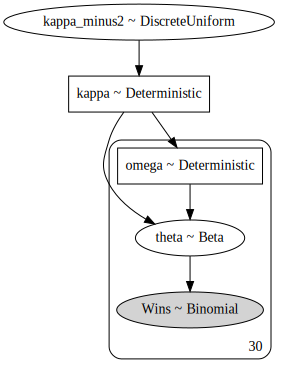

In [187]:
with pm.Model() as hierarchical_model_1819:
    #kappa_minus2 = pm.Uniform('kappa_minus2', 2, 84)
    kappa_minus2 = 82 - pm.DiscreteUniform('kappa_minus2', 2, 84)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    omega = pm.Deterministic('omega', pm.math.dot(1/(kappa - 2), ((df18['Proj']/82) - 1)))
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_teams)
            
    y = pm.Binomial('Wins', n=n_teams, p=theta, observed=df18['Wins'])
pm.model_to_graphviz(hierarchical_model_1819)
#with hierarchical_model_1819:
#    trace_1819 = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})
#pm.traceplot(trace_1819, var_names=['theta'], compact=True)

In [186]:
with hierarchical_model_1819:
    trace_1819 = pm.sample(5000, cores=2, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa_minus2]
Sampling 2 chains:   7%|▋         | 813/11000 [02:35<32:31,  5.22draws/s]  


ValueError: Not enough samples to build a trace.

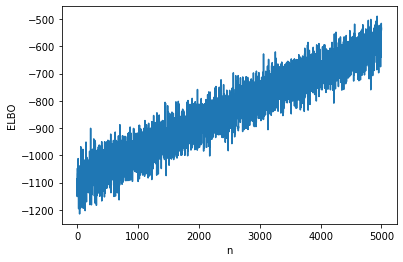

In [181]:
advi_elbo = pd.DataFrame(
    {'ELBO': testfit.hist,
     'n': np.arange(testfit.hist.shape[0])})

plt.plot(-testfit.hist)
plt.xlabel('n')
plt.ylabel('ELBO');

In [182]:
testtratestfit.sample(5000)